## Embedding preparing

Load embedding from SpikeGPT

In [1]:
# Clone needed data and repositories
!git clone https://huggingface.co/ridger/SpikeGPT-OpenWebText-216M
!git clone https://github.com/ridgerchu/SpikeGPT.git
!pip install torch matplotlib numpy tqdm torchvision scipy ninja accelerate transformers torch_geometric


Cloning into 'SpikeGPT-OpenWebText-216M'...
remote: Enumerating objects: 13, done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 13
Unpacking objects: 100% (13/13), 1.51 KiB | 257.00 KiB/s, done.
Cloning into 'SpikeGPT'...
remote: Enumerating objects: 267, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 267 (delta 47), reused 15 (delta 7), pack-reused 187
Receiving objects: 100% (267/267), 1.28 MiB | 5.10 MiB/s, done.
Resolving deltas: 100% (104/104), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.9 MB/s eta 0:00:00


In [2]:
import matplotlib.ticker as ticker
import numpy as np
import math, os, sys, types, time, gc
import torch
from torch import nn

def prepare_env():
    try:
        os.environ["CUDA_VISIBLE_DEVICES"] = sys.argv[1]
    except:
        pass
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cuda.matmul.allow_tf32 = True
    np.set_printoptions(precision=4, suppress=True, linewidth=200)
    args = types.SimpleNamespace()

    args.RUN_DEVICE = "cpu" # 'cuda' // 'cpu' (already fast)
    args.FLOAT_MODE = "fp32" # fp16 (good for GPU, does not work for CPU) // fp32 (good for CPU) // bf16 (less accurate, but works for CPU)
    os.environ["RWKV_JIT_ON"] = '1' # '1' or '0'. very useful for GPU/CPU fp32, but might be harmful for GPU fp16. please benchmark !!!
    vocab_size = 50277

    # MODEL_NAME = model_path + 'SpikeGPT-216M'
    n_layer = 18
    n_embd = 768
    ctx_len = 1024

    # args.MODEL_NAME = MODEL_NAME
    args.n_layer = n_layer
    args.n_embd = n_embd
    args.ctx_len = ctx_len
    args.vocab_size = vocab_size
    args.head_qk = 0
    args.pre_ffn = 0
    args.grad_cp = 0
    args.my_pos_emb = 0
    os.environ["RWKV_RUN_DEVICE"] = args.RUN_DEVICE
    return args

In [3]:
%cd SpikeGPT
args = prepare_env()

from src.utils import TOKENIZER
from src.model_run import RWKV_RNN

def load_embedding_weights(model_path, args):
    # Return nn.Embedding with weights from SpikeGPT embedding
    MODEL_NAME = model_path + 'SpikeGPT-216M'
    args.MODEL_NAME = MODEL_NAME

    # Load pretrained state
    model = RWKV_RNN(args)

    # Get embedding layer from the model
    emb = nn.Embedding(num_embeddings=args.vocab_size, embedding_dim=args.n_embd)
    emb.weight.data = model.w.emb.weight.data

    return emb

def load_tokenizer():
    TOKEN_MODE = "pile"
    WORD_NAME = [
        "20B_tokenizer.json",
        "20B_tokenizer.json",
    ]  # [vocab, vocab] for Pile model
    UNKNOWN_CHAR = None

    tokenizer = TOKENIZER(WORD_NAME, UNKNOWN_CHAR=UNKNOWN_CHAR)
    if TOKEN_MODE == "pile":
        assert tokenizer.tokenizer.decode([187]) == '\n'
    return tokenizer


def transform_text_pretrained_embedding(text, emb, tokenizer):
    if tokenizer.charMode:
        context = tokenizer.refine_context(text)
        ctx = [tokenizer.stoi.get(s, tokenizer.UNKNOWN_CHAR) for s in text]
    else:
        ctx = tokenizer.tokenizer.encode(text)
    # print("Number of tokens:", len(ctx))

    return emb(torch.tensor(ctx))


emb = load_embedding_weights("/content/SpikeGPT-OpenWebText-216M/", args)
tokenizer = load_tokenizer()
%cd ..

/content/SpikeGPT

RWKV_HEAD_QK_DIM 0 RWKV_JIT_ON 1

emb.weight                               float32    cpu
blocks.0.ln1.weight                      float32    cpu
blocks.0.ln1.bias                        float32    cpu
blocks.0.ln2.weight                      float32    cpu
blocks.0.ln2.bias                        float32    cpu
blocks.0.ln0.weight                      float32    cpu
blocks.0.ln0.bias                        float32    cpu
blocks.0.att.time_decay                  float32    cpu
blocks.0.att.time_first                  float32    cpu
blocks.0.att.time_mix_k                  float32    cpu
blocks.0.att.time_mix_v                  float32    cpu
blocks.0.att.time_mix_r                  float32    cpu
blocks.0.att.key.weight                  float32    cpu
blocks.0.att.value.weight                float32    cpu
blocks.0.att.receptance.weight           float32    cpu
blocks.0.att.output.weight               float32    cpu
blocks.0.ffn.time_mix_k                  float32   

In [4]:
text = "In a shocking finding, scientist discovered a herd of dragons living in a remote, previously unexplored valley, in Tibet."
len(tokenizer.tokenizer.encode(text))

24

In [5]:
text = "In a shocking finding, scientist discovered a herd of dragons living in a remote, previously unexplored valley, in Tibet."
result = transform_text_pretrained_embedding(text, emb, tokenizer)
result.shape

torch.Size([24, 768])

# Graph creation

In [7]:
!pip install gdown
!pip install torch_geometric

In [8]:
import gdown

url = "https://drive.google.com/drive/folders/1Jx3Cz7t0hiNdtlBWUdPjhtLwPOH3LtzC"
output = './'

gdown.download_folder(url, output = output, quiet = True)

['./webnlg/test.json',
 './webnlg/test.source',
 './webnlg/test.target',
 './webnlg/train.json',
 './webnlg/val.json']

In [9]:
import json
file_dir = "./webnlg/"

with open (file_dir + "train.json", "r") as f:
    train_set = json.load(f)


with open (file_dir + "val.json", "r") as f:
    val_set = json.load(f)


with open (file_dir + "test.json", "r") as f:
    test_set = json.load(f)

test_set[2]['kbs']

{'W1016': ['California',
  'California',
  [['is part of', 'Anaheim, California']]],
 'W1277': ['United States',
  'United States',
  [['location', 'United States House of Representatives']]],
 'W3706': ['United States House of Representatives',
  'United States House of Representatives',
  [['leader title', 'Anaheim, California']]]}

In [10]:
def get_triplets(dataset_element):
    triplets = []
    for key, value in dataset_element['kbs'].items():
        triplets.append([value[0]]+value[-1][0])
    return triplets

get_triplets(test_set[2])

[['California', 'is part of', 'Anaheim, California'],
 ['United States', 'location', 'United States House of Representatives'],
 ['United States House of Representatives',
  'leader title',
  'Anaheim, California']]

Albany , Georgia is in the United States , a country led by the President of the United States and where the inhabitants are called Americans . One of the ethnic groups in the country are the African Americans

In [11]:
import numpy as np
import torch
from torch_geometric.data import Data

def get_tokens(nodes_list, averaging=False):
    global emb, tokenizer
    result = []
    for el in nodes_list:
        embeddings = transform_text_pretrained_embedding(el, emb, tokenizer)
        result.append(embeddings.detach().tolist())
    return result

def replace_embedding(nodes_tokens):
    global emb
    res = []
    for n in nodes_tokens:
        res.append([])
        for i in n:
            print(i)
            res[-1].append(emb(i))
    return res

def create_graph(triplets, text, with_text=True):
    x = []
    edge_index = []
    y = text

    for t in triplets:

        # Create nodes as unique words
        if t[0] not in x:
            x.append(t[0])
        if t[2] not in x:
            x.append(t[2])

        # Add edge
        edge_index.append([x.index(t[0]), x.index(t[2])])

    x = get_tokens(x, averaging=True)
    k = 3
    # print(len(x))
    for i in range(len(x)):
        if len(x[i]) < k:
            x[i] += emb(torch.tensor( [1] * (k - len(x[i])))).detach().tolist()
        else:
            x[i] = x[i][:k]
        x[i] = sum(x[i], [])
    x = torch.tensor(x)

    edge_index = np.array(edge_index).T
    edge_index = torch.tensor(edge_index, dtype=torch.long)

    # Do not store initial text for train sets
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    return data

data = create_graph(get_triplets(test_set[0]), test_set[0]['text'][0], with_text=True)

In [13]:
get_triplets(test_set[0])

[['Pakistan', 'location', 'Allama Iqbal International Airport'],
 ['2900.0', 'runway length', 'Allama Iqbal International Airport'],
 ['Pakistan Civil Aviation Authority',
  'operating organisation',
  'Allama Iqbal International Airport'],
 ['Lahore', 'city served', 'Allama Iqbal International Airport']]

In [14]:
import torch
from torch_geometric.data import InMemoryDataset, download_url
import json

class GraphDataset(InMemoryDataset):
    def __init__(self, root, file_path, transform=None, pre_transform=None, pre_filter=None):
        self.file_path = file_path
        super().__init__(root, transform, pre_transform, pre_filter)
        self.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [self.file_path]

    @property
    def processed_file_names(self):
        return [".".join(self.file_path.split(".")[:-1])+".pt"]

    def download(self):
        # Download to `self.raw_dir`.
        if ".pt" not in self.raw_file_names[0]:
            with open (self.raw_file_names[0], "r") as f:
                return json.load(f)
        else:
            return torch.load("processed/"+self.raw_file_names[0])

    def process(self):
        # Read data into huge `Data` list.
        data_list = []

        if ".pt" in self.raw_file_names[0]:
            return
        data  = self.download()
        for datapoint in data:
            data_list.append(create_graph(get_triplets(datapoint), datapoint['text'][0]))
        # print("processing")
        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.save(data_list, self.processed_paths[0])

In [ ]:
%mkdir processed
%mkdir processed/webnlg

val_dataset = GraphDataset("./", "webnlg/val.json")
train_dataset = GraphDataset("./", "webnlg/train.json")
test_dataset = GraphDataset("./", "webnlg/test.json")

In [16]:
import gc
gc.collect()

9

In [17]:
val_dataset[0].x.shape

torch.Size([4, 2304])

## Graph visualization

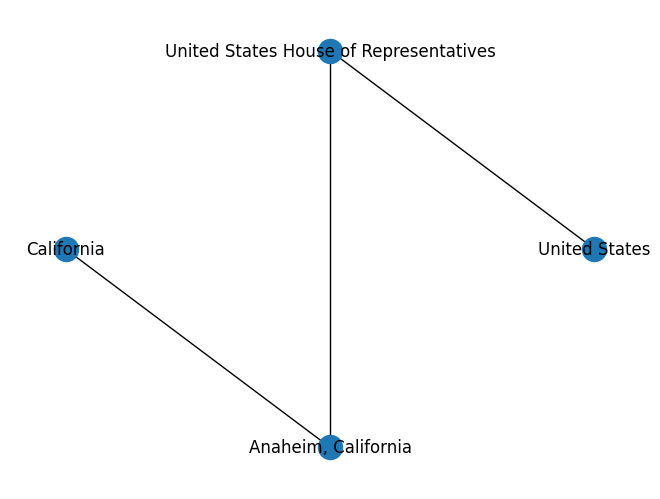

In [ ]:
import numpy as np
import torch
from torch_geometric.data import Data
import torch_geometric
import networkx as nx

def get_tokens(nodes_list, averaging=False):
    global emb, tokenizer
    result = []
    for el in nodes_list:
        embeddings = transform_text_pretrained_embedding(el, emb, tokenizer)
        result.append(embeddings.detach().tolist())
    return result

def replace_embedding(nodes_tokens):
    global emb
    res = []
    for n in nodes_tokens:
        res.append([])
        for i in n:
            print(i)
            res[-1].append(emb(i))
    return res

def create_graph_in_text(triplets, text):
    x = []
    edge_index = []
    edge_attr = []
    y = text

    for t in triplets:

        # Create nodes as unique words
        if t[0] not in x:
            x.append(t[0])
        if t[2] not in x:
            x.append(t[2])

        # Add edge
        ind1, ind2 = x.index(t[0]), x.index(t[2])
        edge_index.append([min(ind1, ind2), max(ind1, ind2)])

        # Add edge attribute
        edge_attr.append(t[1])

    edge_index = np.array(edge_index).T
    edge_index = torch.tensor(edge_index, dtype=torch.long)

    # Do not store initial text for train sets
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=text)
    return data

def draw_graph(graph):
    data = create_graph_in_text(get_triplets(graph),graph['text'][0])
    g = torch_geometric.utils.to_networkx(data, to_undirected=True)
    nx.draw_shell(g, labels={i:p for i, p in enumerate(data.x)})

draw_graph(test_set[2])

# Load Spike GPT model

In [18]:
# !git clone https://huggingface.co/ridger/SpikeGPT-OpenWebText-216M
# !git clone https://github.com/ridgerchu/SpikeGPT.git
# !pip install torch matplotlib numpy tqdm torchvision scipy ninja accelerate transformers
# !pip install gdown torch_geometric

In [19]:
import os
os.rename("./SpikeGPT-OpenWebText-216M/SpikeGPT-216M.pth", "./SpikeGPT/SpikeGPT-216M.pth")
%rm -r "./SpikeGPT-OpenWebText-216M/"
!git clone https://huggingface.co/ridger/SpikeGPT-OpenWebText-216M

Cloning into 'SpikeGPT-OpenWebText-216M'...
remote: Enumerating objects: 13, done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 13
Unpacking objects: 100% (13/13), 1.51 KiB | 386.00 KiB/s, done.


In [20]:
import matplotlib.ticker as ticker
import numpy as np
import math, os, sys, types, time, gc
import torch
from torch import nn

def prepare_env():
    try:
        os.environ["CUDA_VISIBLE_DEVICES"] = sys.argv[1]
    except:
        pass
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cuda.matmul.allow_tf32 = True
    np.set_printoptions(precision=4, suppress=True, linewidth=200)
    args = types.SimpleNamespace()

    args.RUN_DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' # 'cuda' // 'cpu' (already fast)
    args.FLOAT_MODE = "fp32" # fp16 (good for GPU, does not work for CPU) // fp32 (good for CPU) // bf16 (less accurate, but works for CPU)
    os.environ["RWKV_JIT_ON"] = '1' # '1' or '0'. very useful for GPU/CPU fp32, but might be harmful for GPU fp16. please benchmark !!!
    vocab_size = 50277

    # MODEL_NAME = model_path + 'SpikeGPT-216M'
    n_layer = 18
    n_embd = 768
    ctx_len = 1024

    args.MODEL_NAME = 'SpikeGPT-216M'

    # args.MODEL_NAME = MODEL_NAME
    args.n_layer = n_layer
    args.n_embd = n_embd
    args.ctx_len = ctx_len
    args.vocab_size = vocab_size
    args.head_qk = 0
    args.pre_ffn = 0
    args.grad_cp = 0
    args.my_pos_emb = 0
    os.environ["RWKV_RUN_DEVICE"] = args.RUN_DEVICE
    return args

In [21]:
%cd SpikeGPT
args = prepare_env()

from src.utils import TOKENIZER
from src.model_run import RWKV_RNN

def load_tokenizer():
    TOKEN_MODE = "pile"
    WORD_NAME = [
        "20B_tokenizer.json",
        "20B_tokenizer.json",
    ]  # [vocab, vocab] for Pile model
    UNKNOWN_CHAR = None

    tokenizer = TOKENIZER(WORD_NAME, UNKNOWN_CHAR=UNKNOWN_CHAR)
    if TOKEN_MODE == "pile":
        assert tokenizer.tokenizer.decode([187]) == '\n'
    return tokenizer

def tokenize(text, tokenizer):
    if type(text) == str:
        text = text.lower()
    if tokenizer.charMode:
        context = tokenizer.refine_context(text)
        ctx = [tokenizer.stoi.get(s, tokenizer.UNKNOWN_CHAR) for s in context]
    else:
        ctx = tokenizer.tokenizer.encode(text)
    # print("Number of tokens:", len(ctx))

    return ctx

def run_spike_gpt(model, context, ctx, args, tokenizer, num_trials=2, length_per_trial = 100):
    # Code is based on SpikeGPT run.py, but changed for this project
    # To be able to use with the created model
    # ctx = sequence of input tokens
    # Context - real sentence
    ctx_len = args.ctx_len

    TOKEN_MODE = "pile"

    src_len = len(ctx)
    src_ctx = ctx.copy()

    TEMPERATURE = 1.5
    top_p = 0.7
    top_p_newline = 0.9  # only used in TOKEN_MODE = char

    DEBUG_DEBUG = False  # True False --> show softmax output

    print("\nYour prompt has " + str(src_len) + " tokens.")

    time_slot = {}
    time_ref = time.time_ns()

    def record_time(name):
        if name not in time_slot:
            time_slot[name] = 1e20
        tt = (time.time_ns() - time_ref) / 1e9
        if tt < time_slot[name]:
            time_slot[name] = tt

    init_state = None
    init_out = None
    state = None
    mem1 = None
    mem2 = None
    out = None

    for TRIAL in range(1 if DEBUG_DEBUG else num_trials):
        print(("-" * 50) + '\n' + context)

        time_ref = time.time_ns()
        ctx = src_ctx.copy()

        if TRIAL == 0:
            for i in range(src_len):
                x = ctx[: i + 1]
                if i == src_len - 1:
                    init_out, init_state, mem1, mem2 = model.forward(x, init_state, mem1, mem2)
                else:
                    init_state, mem1, mem2 = model.forward(x, init_state, mem1, mem2, preprocess_only=True)
            gc.collect()
            torch.cuda.empty_cache()

        record_time('preprocess')
        out_last = src_len
        for i in range(src_len, src_len + (1 if DEBUG_DEBUG else length_per_trial)):
            x = ctx[: i + 1]
            x = x[-ctx_len:]

            if i == src_len:
                out = init_out.clone()
                state = init_state.clone()
            else:
                out, state, mem1, mem2 = model.forward(x, state, mem1, mem2)
            if DEBUG_DEBUG:
                print("model", np.array(x), "==>", np.array(out), np.max(out.cpu().numpy()), np.min(out.cpu().numpy()))
            if TOKEN_MODE == "pile":
                out[0] = -999999999  # disable <|endoftext|>

            ttt = tokenizer.sample_logits(
                out,
                x,
                ctx_len,
                temperature=TEMPERATURE,
                top_p_usual=top_p,
                top_p_newline=top_p_newline,
            )
            ttt = int(ttt)
            ctx += [ttt]

            if tokenizer.charMode:
                char = tokenizer.itos[ttt]
                print(char, end="", flush=True)
            else:
                char = tokenizer.tokenizer.decode(ctx[out_last:])
                if '\ufffd' not in char: # is valid utf8 string?
                    print(char, end="", flush=True)
                    out_last = i+1

        record_time('total')
        print(
            f"\n\n--- preprocess {round(time_slot['preprocess'], 2)}s, generation {round(time_slot['total']-time_slot['preprocess'], 2)}s ", end = ''
        )

    print(("-" * 50) + '\n')


tokenizer = load_tokenizer()
spike_gpt = get_spike_gpt_model(args)
%cd ..

/content/SpikeGPT
emb.weight                               float32    cpu
blocks.0.ln1.weight                      float32    cpu
blocks.0.ln1.bias                        float32    cpu
blocks.0.ln2.weight                      float32    cpu
blocks.0.ln2.bias                        float32    cpu
blocks.0.ln0.weight                      float32    cpu
blocks.0.ln0.bias                        float32    cpu
blocks.0.att.time_decay                  float32    cpu
blocks.0.att.time_first                  float32    cpu
blocks.0.att.time_mix_k                  float32    cpu
blocks.0.att.time_mix_v                  float32    cpu
blocks.0.att.time_mix_r                  float32    cpu
blocks.0.att.key.weight                  float32    cpu
blocks.0.att.value.weight                float32    cpu
blocks.0.att.receptance.weight           float32    cpu
blocks.0.att.output.weight               float32    cpu
blocks.0.ffn.time_mix_k                  float32    cpu
blocks.0.ffn.time_mix_r       

In [23]:
text = "Hello, my friend"
run_spike_gpt(spike_gpt, text, tokenize(text, tokenizer), args, tokenizer)


Your prompt has 4 tokens.
--------------------------------------------------
Hello, my friend
 for many

/content/SpikeGPT/src/utils.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  probs = F.softmax(torch.tensor(out), dim=-1)


 years now. I love a blog post on you and this is my first place to start writing. I think this is a great time to try it out, so please be clear! If you like it, don’t forget to post it on Facebook, and enjoy it. I would love to hear what you think about this post!

UPDATE (January 15, 2014): This article has been updated with additional details. I have removed this post because it was incorrect. The article

--- preprocess 0.59s, generation 8.85s --------------------------------------------------
Hello, my friend
 who is my cat who is all about you, and who just got upset and said, “Oh my God, there are no cats out there, there’s no cats.” So when you went back and saw him and said, “Yeah, yeah, I think I’m not going to see you. I don’t care if it’s you or not.” And that was when it got weird, and the dogs were like, “Yeah, it’s funny.” And it

--- preprocess 0.0s, generation 9.44s --------------------------------------------------



# Load preprocessed data



In [ ]:
import gdown
import os

url = "https://drive.google.com/drive/folders/1w8wUtjpC_3FgNFK9URWTsqcg5h6QpqAY"
gdown.download_folder(url)
os.rename('./WebNLG_graph_dataset', './processed')

Retrieving folder list


Processing file 1Qy2NnIbg0NuZm-8SkvNoh3a8VBOhhmRm test.pt
Processing file 1OlEdxK6u4CmEHFPPy05avSD3nICxkXj5 train.pt
Processing file 174XxA3OJx6CWw7cVvdYGUbMy7Yvtx1Rp val.pt
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1Qy2NnIbg0NuZm-8SkvNoh3a8VBOhhmRm
To: /content/WebNLG_graph_dataset/test.pt
100%|██████████| 174M/174M [00:06<00:00, 28.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OlEdxK6u4CmEHFPPy05avSD3nICxkXj5
To: /content/WebNLG_graph_dataset/train.pt
100%|██████████| 1.40G/1.40G [00:23<00:00, 59.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=174XxA3OJx6CWw7cVvdYGUbMy7Yvtx1Rp
To: /content/WebNLG_graph_dataset/val.pt
100%|██████████| 178M/178M [00:03<00:00, 47.9MB/s]
Download completed


In [ ]:
import torch
from torch_geometric.data import InMemoryDataset, download_url
import json


class GraphDataset(InMemoryDataset):
    def __init__(self, root, file_path, transform=None, pre_transform=None, pre_filter=None):
        self.file_path = file_path
        super().__init__(root, transform, pre_transform, pre_filter)
        self.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [self.file_path]

    @property
    def processed_file_names(self):
        return [".".join(self.file_path.split(".")[:-1])+".pt"]

    def download(self):
        # Download to `self.raw_dir`.
        if ".pt" not in self.raw_file_names[0]:
            with open (self.raw_file_names[0], "r") as f:
                return json.load(f)
        else:
            return torch.load("processed/"+self.raw_file_names[0])

    def process(self):
        # Read data into huge `Data` list.
        data_list = []

        if ".pt" in self.raw_file_names[0]:
            return
        data  = self.download()
        for datapoint in data:
            data_list.append(create_graph(get_triplets(datapoint), datapoint['text'][0]))
        # print("processing")
        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.save(data_list, self.processed_paths[0])

In [ ]:
train_dataset = GraphDataset("./", "train.pt")
val_dataset = GraphDataset("./", "val.pt")
test_dataset = GraphDataset("./", "test.pt")

# Huge model

In [24]:
import math
import time
import random
from typing import Tuple

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor

from torch_geometric.nn import GCNConv , GraphConv
from tqdm import tqdm

In [ ]:
import warnings
warnings.simplefilter('ignore')

In [25]:
class Encoder(nn.Module):
    def __init__(self,
                 input_dim: int,
                 emb_dim: int,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 dropout: float):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout

        self.conv = GraphConv(input_dim, emb_dim)

        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)

        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)

        self.dropout = nn.Dropout(dropout)


    def forward(self, src: Tensor, edge_index):
        emb = self.conv(src, edge_index)

        embedded = self.dropout(emb)
        embedded = torch.mean(embedded, dim=0).unsqueeze(0).unsqueeze(0)

        outputs, hidden = self.rnn(embedded)

        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        hidden = torch.tanh(self.fc(hidden))

        return outputs, hidden


class Attention(nn.Module):
    def __init__(self,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 attn_dim: int):
        super().__init__()

        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim

        self.attn_in = (enc_hid_dim * 2) + dec_hid_dim

        self.attn = nn.Linear(self.attn_in, attn_dim)

    def forward(self,
                decoder_hidden: Tensor,
                encoder_outputs: Tensor) -> Tensor:

        src_len = encoder_outputs.shape[0]

        repeated_decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, src_len, 1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        energy = torch.tanh(self.attn(torch.cat((
            repeated_decoder_hidden,
            encoder_outputs),
            dim = 2)))

        attention = torch.sum(energy, dim=2)

        return F.softmax(attention, dim=1)

class Decoder(nn.Module):
    def __init__(self,
                 output_dim: int,
                 emb_dim: int,
                 enc_hid_dim: int,
                 dec_hid_dim: int,
                 dropout: int,
                 attention: nn.Module):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)

        self.out = nn.Linear(self.attention.attn_in + emb_dim, output_dim)

        self.dropout = nn.Dropout(dropout)


    def _weighted_encoder_rep(self,
                              decoder_hidden: Tensor,
                              encoder_outputs: Tensor) -> Tensor:

        a = self.attention(decoder_hidden, encoder_outputs)

        a = a.unsqueeze(1)

        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        weighted_encoder_rep = torch.bmm(a, encoder_outputs)

        weighted_encoder_rep = weighted_encoder_rep.permute(1, 0, 2)

        return weighted_encoder_rep


    def forward(self,
                input: Tensor,
                decoder_hidden: Tensor,
                encoder_outputs: Tensor):

        input = input.unsqueeze(0)

        embedded = self.embedding(input)

        weighted_encoder_rep = self._weighted_encoder_rep(decoder_hidden,
                                                          encoder_outputs)

        rnn_input = torch.cat((embedded, weighted_encoder_rep), dim = 2)
        output, decoder_hidden = self.rnn(rnn_input, decoder_hidden.unsqueeze(0))

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted_encoder_rep = weighted_encoder_rep.squeeze(0)

        output = self.out(torch.cat((output,
                                     weighted_encoder_rep,
                                     embedded), dim = 1))

        return output, decoder_hidden.squeeze(0)

class Graph2Seq(nn.Module):
    def __init__(self,
                 encoder: nn.Module,
                 decoder: nn.Module,
                 device: torch.device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self,
                src: Tensor, edge_index,
                trg: Tensor,
                teacher_forcing_ratio: float = 0.5) -> Tensor:

        batch_size = 1
        if type(trg) == int:
            max_len = trg
            output = torch.tensor([1])
        else:
            max_len = trg.shape[0]
            trg = trg.unsqueeze(1)
            output = trg[0]

        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src, edge_index)

        for t in range(1, max_len):
            output, hidden = self.decoder(output, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            output = (trg[t] if teacher_force and type(trg) != int else top1)

        return outputs

In [26]:
# HIDDEN_DIM = 1024
# OUTPUT_DIM = 50277
# MAX_OUT_SIZE = 103

INPUT_DIM = train_dataset.num_features
OUTPUT_DIM = 50277

ENC_EMB_DIM = 768
DEC_EMB_DIM = 768
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ATTN_DIM = 64
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

# ENC_EMB_DIM = 32
# DEC_EMB_DIM = 768
# ENC_HID_DIM = 64
# DEC_HID_DIM = 64
# ATTN_DIM = 8
# ENC_DROPOUT = 0.5
# DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)

attn = Attention(ENC_HID_DIM, DEC_HID_DIM, ATTN_DIM)

dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

graph_to_tokens = Graph2Seq(enc, dec, device).to(device)


def init_weights(m: nn.Module):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)


graph_to_tokens.apply(init_weights)
graph_to_tokens.decoder.embedding.weight.data = spike_gpt.w.emb.weight.data
# graph_to_tokens.decoder.embedding.requires_grad = False

optimizer = torch.optim.Adam(graph_to_tokens.parameters())

PAD_IDX = 1

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)


In [50]:
import math
import time


def train(model: nn.Module,
          train_dataset,
          optimizer: torch.optim.Optimizer,
          criterion: nn.Module,
          clip: float, batch_num, batch_size):
    # Training loop

    model.train()

    epoch_loss = 0
    counter = 0

    # progress bar
    progress = tqdm(range(batch_num * batch_size, min((batch_num + 1) * batch_size, len(train_dataset))), desc="Train loss: ", total=batch_size)

    for i in progress:

        # training step for single batch
        labels = tokenize(train_dataset[i].y, tokenizer)
        labels = F.pad(torch.tensor(labels), (1, 0), value=PAD_IDX).to(device)

        graphs = train_dataset[i].to(device)
        output = model(graphs.x, graphs.edge_index, labels, 0.5)
        output = output[1:].view(-1, output.shape[-1])
        trg = labels[1:].view(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        cur_loss = loss.item()
        epoch_loss += cur_loss
        counter+=1

        progress.set_description("Train loss: {:.7f}".format(epoch_loss / counter ))

    if counter == 0:
        return 0
    return epoch_loss / batch_size


def evaluate(model: nn.Module,
             train_dataset,
             criterion: nn.Module, batch_num, batch_size):

    model.eval()
    counter = 0
    epoch_loss = 0

    with torch.no_grad():
        # progress bar
        progress = tqdm(range(batch_num * batch_size, min((batch_num + 1) * batch_size, len(train_dataset))), desc="Validation loss:", total=batch_size)

        for i in progress:
            graphs = train_dataset[i].to(device)

            # training step for single batch
            labels = tokenize(train_dataset[i].y, tokenizer)
            labels = F.pad(torch.tensor(labels), (1, 0), value=PAD_IDX).to(device)
            output = model(graphs.x, graphs.edge_index, labels.shape[0], 0)

            output = output[1:].view(-1, output.shape[-1])
            trg = labels[1:].view(-1)
            loss = criterion(output, trg)


            cur_loss = loss.item()
            epoch_loss += cur_loss
            counter+=1

            progress.set_description("Validation loss: {:.7f}".format(epoch_loss / counter ))

    if counter == 0:
        return 0
    return epoch_loss / counter


def epoch_time(start_time: int,
               end_time: int):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def run_epochs(batch_size, val_size, test_size, train_batch_num, tokenizer, n_epochs=1):
    CLIP = 1
    batch_num = train_batch_num
    graph_to_tokens.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):

        start_time = time.time()
        for batch_id in range(batch_num):
            # Train on subset
            train_loss = train(graph_to_tokens, train_dataset, optimizer, criterion, CLIP, batch_id, batch_size,
                               tokenizer)
            # Evaluate on subset
            valid_loss = evaluate(graph_to_tokens, val_dataset, criterion, batch_id, val_size, tokenizer)

            train_losses.append(train_loss)
            val_losses.append(valid_loss)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        print(f'\n\nEpoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    test_loss = evaluate(graph_to_tokens, test_dataset, criterion, 1, test_size)

    print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')
    return train_losses, val_losses, test_loss


In [51]:
# Run epoch 1
train_losses, val_losses, test_losses = run_epochs(15, 3, 15, 20)

Validation loss: 7.7749152: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]




Epoch: 01 | Time: 93m 14s
	Train Loss: 6.842 | Train PPL: 936.032
	 Val. Loss: 7.775 |  Val. PPL: 2380.141


Validation loss: 7.2161287: 100%|██████████| 15/15 [00:16<00:00,  1.11s/it]

| Test Loss: 7.216 | Test PPL: 1361.209 |


In [72]:
# Run epoch 2
tr_losses, v_losses, te_losses = run_epochs(15, 3, 15, 20)

Validation loss: 8.4784368: 100%|██████████| 3/3 [00:02<00:00,  1.31it/s]




Epoch: 01 | Time: 95m 4s
	Train Loss: 5.684 | Train PPL: 294.208
	 Val. Loss: 8.478 |  Val. PPL: 4809.925


Validation loss: 7.9139579: 100%|██████████| 15/15 [00:15<00:00,  1.04s/it]

| Test Loss: 7.914 | Test PPL: 2735.195 |


In [53]:
# Save model weights
torch.save(graph_to_tokens.state_dict(), "/content/model_graph_to_tokens.pt")

## Predictions

In [66]:
def predict(model: nn.Module,
             graph,
             criterion: nn.Module, tokenizer):
    # Make a single prediction
    model.eval()

    with torch.no_grad():

        graphs = graph.to(device)

        # training step for single batch
        labels = tokenize(graph.y.lower(), tokenizer)
        labels = F.pad(torch.tensor(labels), (1, 0), value=PAD_IDX).to(device)
        # print(labels)
        false_trg = torch.ones(labels.shape)
        output = model(graphs.x, graphs.edge_index, labels.shape[0] , 0)

        output = output[1:].view(-1, output.shape[-1])
        trg = labels[1:]
        # .view(-1, output.shape[-1])

        loss = criterion(output, trg)


        cur_loss = loss.item()
        print("Loss:", cur_loss)


    return output.max(1)[1]


In [78]:
def run_graph_spike_gpt(graph, spike_gpt, args, graph_to_tokens, criterion, tokenizer, device, num_trials=2, length_per_trial = 100):
    # Run full model
    # GraphSpikeGPT
    context = graph.y
    ctx = predict(graph_to_tokens, graph, criterion, tokenizer, device).tolist()
    run_spike_gpt(spike_gpt, context, ctx, args, tokenizer, num_trials, length_per_trial)

# Vizualization

In [ ]:
run_graph_spike_gpt(test_dataset[2], spike_gpt, args, graph_to_tokens, criterion, tokenizer, device)

Loss: 5.986928939819336

Your prompt has 24 tokens.
--------------------------------------------------
Anaheim is part of California and is led by the United States House of Representatives located in the US .
President of France today told the press that the U.S. is "looking to push back" against U.S. sanctions against Iran.

“We want to get our help to counter Iran, but they're going to have to do better," he told reporters at the White House on Thursday, according to the Washington Post.

--- preprocess 2.21s, generation 9.01s --------------------------------------------------


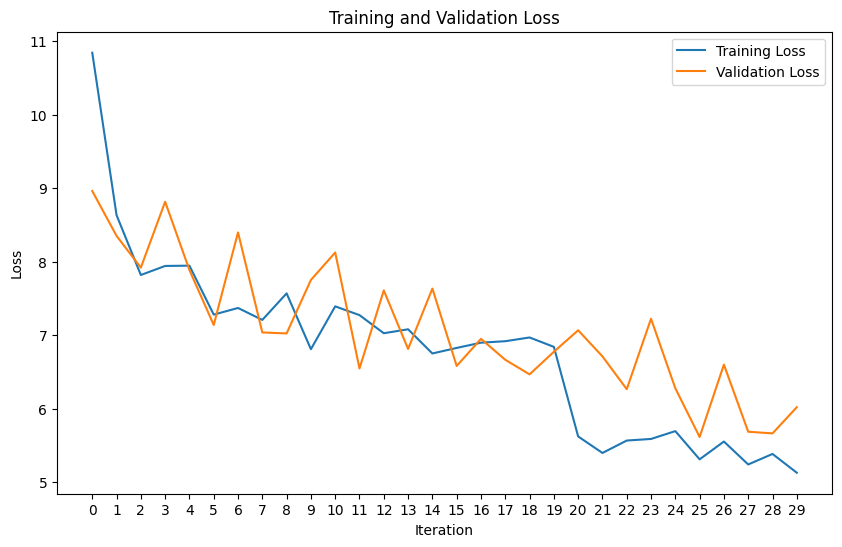

In [ ]:
# Plot train and validation loss
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,6))
# train_losses = []
# val_losses = []
xaxis = np.arange(0, 30, 1)
plt.plot(xaxis, t_loss, label='Training Loss')
plt.plot(xaxis, val_loss, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(xaxis)

# Display the plot
plt.legend(loc='best')
plt.show()